In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/home/rainorangelemon/Documents/Attend-and-Excite


/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import glob
import os
import torch
import numpy as np
import shutil
import json

In [3]:
!ls outputs

ae_sd_1_4			    standard_sd_2_1_lift_filtered
ae_sd_1_4_lift			    standard_sd_xl_lift
ae_sd_2_1_lift			    standard_sd_xl_lift_filtered
ae_sd_2_1_lift_filtered		    standard_sd_xl_lift_ranked
outputs_ae_sd_2_1_lift.tar.gz	    test_lift
outputs_standard_sd_xl_lift.tar.gz  weak_lift
standard_sd_2_1_lift		    weak_lift.tar.gz


In [13]:
target_folder = "outputs/standard_sd_xl_lift"
files_or_folders = glob.glob(target_folder + "/*")

folders = [f for f in files_or_folders if os.path.isdir(f)]

In [14]:
from tqdm import tqdm
metrics_results = []
for t in tqdm(range(200)):
    # create a filtered folder
    filtered_folder = target_folder + "_ranked"
    # clear the folder if it exists
    if os.path.exists(filtered_folder):
        shutil.rmtree(filtered_folder)
    os.makedirs(filtered_folder, exist_ok=True)
    # load the text prompt and the pt files
    for folder in folders:
        num_seeds = len(glob.glob(f"{folder}/*.pt"))
        valid_seeds = []
        scores = []
        for seed in range(num_seeds):
            pt_file = glob.glob(f"{folder}/{seed}_*.pt")[0]
            image_file = glob.glob(f"{folder}/{seed}.png")[0]

            # load the pt file
            pt = torch.load(pt_file)
            scores.append(pt["log_lift_results"][..., t].min().item())

        # choose the one with the highest score
        selected_seed = scores.index(max(scores))

        # copy the corresponding image file and the pt file to the filtered folder
        subfolder = folder.split("/")[-1]
        folder_to_copy_to = os.path.join(filtered_folder+"/", subfolder)
        os.makedirs(folder_to_copy_to, exist_ok=True)
        pt_file_copied = glob.glob(f"{folder}/{selected_seed}_*.pt")[0]
        image_file_copied = glob.glob(f"{folder}/{selected_seed}.png")[0]
        shutil.copy(image_file_copied, os.path.join(folder_to_copy_to, f"{selected_seed}.png"))
        shutil.copy(pt_file_copied, os.path.join(folder_to_copy_to, f"{selected_seed}.pt"))

    # run the clip metrics
    os.system(f"python metrics/compute_clip_similarity.py --output_path={filtered_folder} > /dev/null 2>&1")
    # load the metrics results
    with open(f"./metrics/clip_aggregated_metrics.json", "r") as f:
        metrics_results.append(json.load(f))

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_1022984/700839967.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt = torch.load(pt_file)
  0%|          | 0/200 

IndexError: too many indices for tensor of dimension 6

In [15]:
# save the metrics results
with open(f"./metrics/{target_folder.split('/')[-1].replace('/', '_')}_across_time.json", "w") as f:
    json.dump(metrics_results, f)

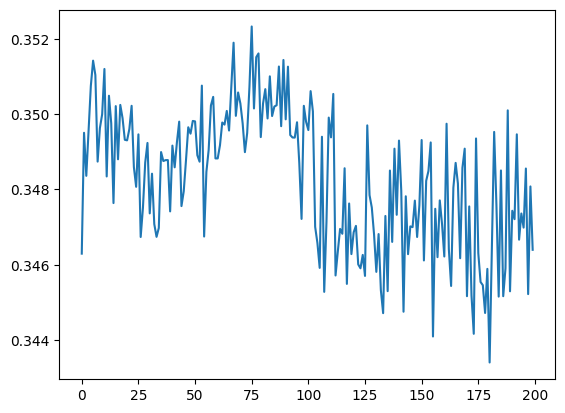

In [16]:
full_text_aggregation = [m["full_text_aggregation"] for m in metrics_results]
# plot the full text aggregation
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(full_text_aggregation)
plt.show()

# Overall Result

In [19]:
from tqdm import tqdm
metrics_results = []
threshold = 1e-3
# create a filtered folder
filtered_folder = target_folder + "_filtered"
# clear the folder if it exists
if os.path.exists(filtered_folder):
    shutil.rmtree(filtered_folder)
os.makedirs(filtered_folder, exist_ok=True)
# load the text prompt and the pt files
for folder in tqdm(folders):
    num_seeds = len(glob.glob(f"{folder}/*_score_results.pt"))
    valid_seeds = []
    scores = []
    for seed in range(num_seeds):
        pt_file = glob.glob(f"{folder}/{seed}_score_results.pt")[0]
        image_file = glob.glob(f"{folder}/{seed}.png")[0]

        # load the pt file
        pt = torch.load(pt_file, weights_only=True, map_location="cuda:0")
        score_object_1_and_object_2 = pt[:, 0]
        score_object_1 = pt[:, 1]
        score_object_2 = pt[:, 2]
        lift_object_1 = (score_object_1_and_object_2 - score_object_1).pow(2).mean(dim=(1, 2))
        lift_object_2 = (score_object_1_and_object_2 - score_object_2).pow(2).mean(dim=(1, 2))
        scores.append(min((lift_object_1 - lift_object_2).max().item(), (lift_object_2 - lift_object_1).max().item()))


    if np.array(scores).max() > threshold:
        # randomly choose one that has a positive score
        # selected_seed = np.random.choice(np.where(np.array(scores) > threshold)[0])
        selected_seed = scores.index(max(scores))
    else:
        print(f"No valid seed found for prompt {folder.split('/')[-1]}")
        # choose the one with the highest score
        selected_seed = scores.index(max(scores))

    # copy the corresponding image file and the pt file to the filtered folder
    subfolder = folder.split("/")[-1]
    folder_to_copy_to = os.path.join(filtered_folder+"/", subfolder)
    os.makedirs(folder_to_copy_to, exist_ok=True)
    pt_file_copied = glob.glob(f"{folder}/{selected_seed}_*.pt")[0]
    image_file_copied = glob.glob(f"{folder}/{selected_seed}.png")[0]
    shutil.copy(image_file_copied, os.path.join(folder_to_copy_to, f"{selected_seed}.png"))
    shutil.copy(pt_file_copied, os.path.join(folder_to_copy_to, f"{selected_seed}.pt"))

# run the clip metrics
os.system(f"python metrics/compute_clip_similarity.py --output_path={filtered_folder} > /dev/null 2>&1")
# load the metrics results
with open(f"./metrics/clip_aggregated_metrics.json", "r") as f:
    metrics_results.append(json.load(f))

  3%|▎         | 9/276 [00:02<01:25,  3.12it/s]

No valid seed found for prompt a yellow glasses and a black car


 10%|█         | 28/276 [00:08<01:18,  3.16it/s]

No valid seed found for prompt a yellow bow and a orange bench


 11%|█         | 31/276 [00:09<01:18,  3.14it/s]

No valid seed found for prompt a horse and a pink chair


 14%|█▍        | 38/276 [00:12<01:18,  3.04it/s]

No valid seed found for prompt a lion and a red car


 14%|█▍        | 40/276 [00:12<01:16,  3.09it/s]

No valid seed found for prompt a purple chair and a red bow


 15%|█▍        | 41/276 [00:13<01:16,  3.07it/s]

No valid seed found for prompt a yellow suitcase and a yellow car


 18%|█▊        | 50/276 [00:16<01:16,  2.95it/s]

No valid seed found for prompt a white chair and a gray balloon


 32%|███▏      | 89/276 [00:28<00:59,  3.16it/s]

No valid seed found for prompt a blue balloon and a orange bench


 34%|███▍      | 95/276 [00:30<00:56,  3.20it/s]

No valid seed found for prompt a white suitcase and a white chair


 37%|███▋      | 101/276 [00:32<00:55,  3.13it/s]

No valid seed found for prompt a cat and a gray bench


 49%|████▊     | 134/276 [00:42<00:44,  3.20it/s]

No valid seed found for prompt a purple chair and a orange bowl


 51%|█████     | 141/276 [00:46<01:07,  2.01it/s]

No valid seed found for prompt a monkey and a blue chair


 55%|█████▍    | 151/276 [00:49<00:40,  3.07it/s]

No valid seed found for prompt a mouse and a purple bowl


 57%|█████▋    | 157/276 [00:51<00:37,  3.18it/s]

No valid seed found for prompt a brown chair and a white bench


 63%|██████▎   | 174/276 [00:57<00:33,  3.09it/s]

No valid seed found for prompt a rabbit and a blue bowl


 65%|██████▍   | 179/276 [00:58<00:31,  3.12it/s]

No valid seed found for prompt a green backpack and a purple bench


 67%|██████▋   | 186/276 [01:01<00:28,  3.12it/s]

No valid seed found for prompt a purple crown and a blue bench


 71%|███████   | 195/276 [01:04<00:25,  3.17it/s]

No valid seed found for prompt a orange car and a red bench


 75%|███████▍  | 206/276 [01:07<00:22,  3.08it/s]

No valid seed found for prompt a yellow backpack and a purple chair


 75%|███████▌  | 208/276 [01:08<00:21,  3.18it/s]

No valid seed found for prompt a bear and a purple bowl


 76%|███████▋  | 211/276 [01:09<00:20,  3.10it/s]

No valid seed found for prompt a monkey and a red car


 77%|███████▋  | 212/276 [01:09<00:20,  3.08it/s]

No valid seed found for prompt a bird and a purple bench


 84%|████████▎ | 231/276 [01:15<00:15,  2.95it/s]

No valid seed found for prompt a purple bowl and a black bench


 84%|████████▍ | 233/276 [01:16<00:14,  3.03it/s]

No valid seed found for prompt a white car and a black bowl


 86%|████████▌ | 236/276 [01:19<00:26,  1.53it/s]

No valid seed found for prompt a cat and a yellow car


 91%|█████████ | 250/276 [01:24<00:08,  3.16it/s]

No valid seed found for prompt a turtle and a blue chair


 91%|█████████ | 251/276 [01:24<00:07,  3.13it/s]

No valid seed found for prompt a pink crown and a red chair


100%|██████████| 276/276 [01:32<00:00,  2.98it/s]


# Analyze

In [20]:
import json
with open(f"./metrics/clip_raw_metrics.json", "r") as f:
    raw_metrics = json.load(f)

In [21]:
raw_metrics

{'a bear and a blue clock': {'first_half': [0.2967284917831421],
  'full_text': [0.3916977047920227],
  'image_names': ['1.png'],
  'second_half': [0.2995498776435852]},
 'a bear and a elephant': {'first_half': [0.20707014203071594],
  'full_text': [0.3042615056037903],
  'image_names': ['3.png'],
  'second_half': [0.2803722023963928]},
 'a bear and a frog': {'first_half': [0.2621926963329315],
  'full_text': [0.37285172939300537],
  'image_names': ['4.png'],
  'second_half': [0.26367437839508057]},
 'a bear and a gray bench': {'first_half': [0.29497337341308594],
  'full_text': [0.37827134132385254],
  'image_names': ['3.png'],
  'second_half': [0.2825062870979309]},
 'a bear and a horse': {'first_half': [0.2809830904006958],
  'full_text': [0.3662545084953308],
  'image_names': ['1.png'],
  'second_half': [0.2807517945766449]},
 'a bear and a lion': {'first_half': [0.2800590693950653],
  'full_text': [0.3457816243171692],
  'image_names': ['1.png'],
  'second_half': [0.27907961606979

a cat and a bird 0.31031084060668945


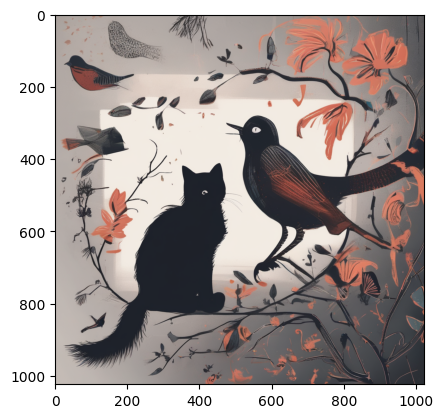

a rabbit and a mouse 0.30769601464271545


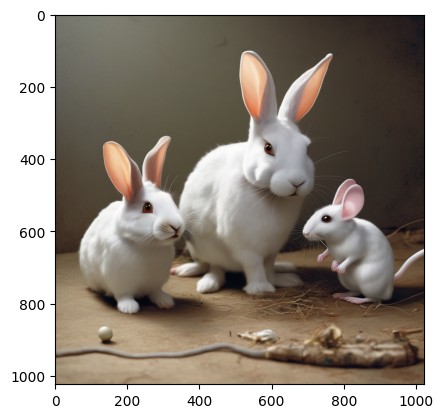

a bear and a elephant 0.3042615056037903


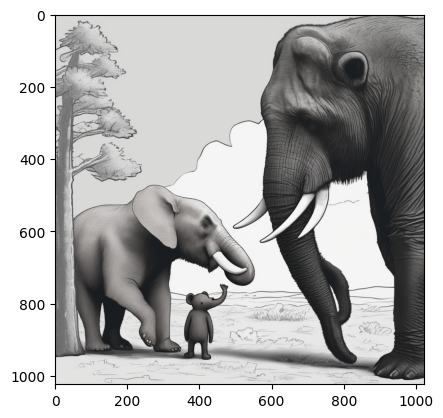

a yellow glasses and a black car 0.30282890796661377


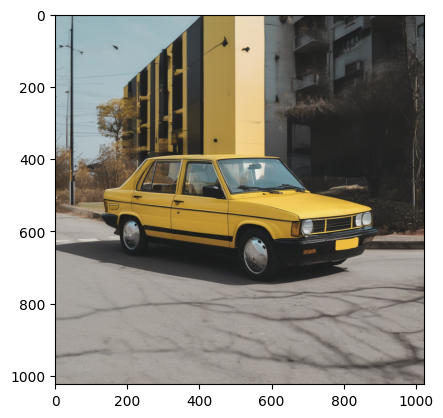

a monkey with a glasses 0.3015176057815552


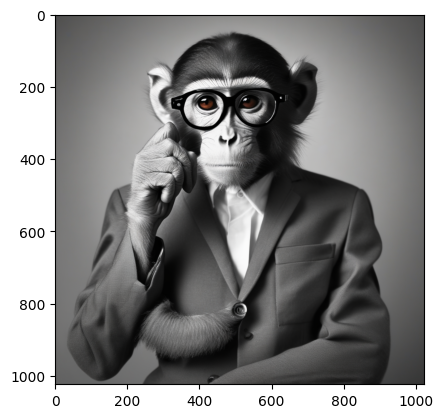

a bear and a mouse 0.29933303594589233


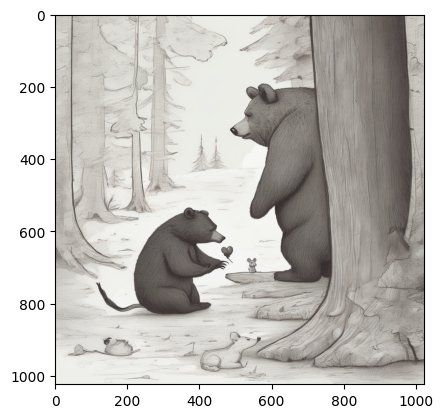

a horse with a bow 0.2955784201622009


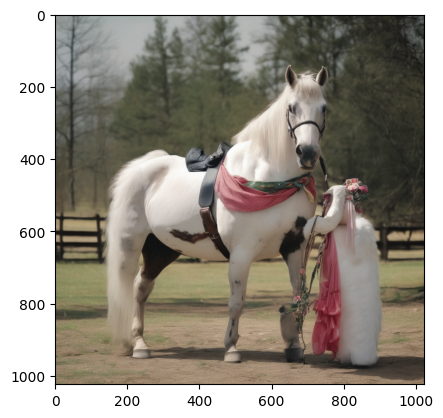

a monkey with a bow 0.28752171993255615


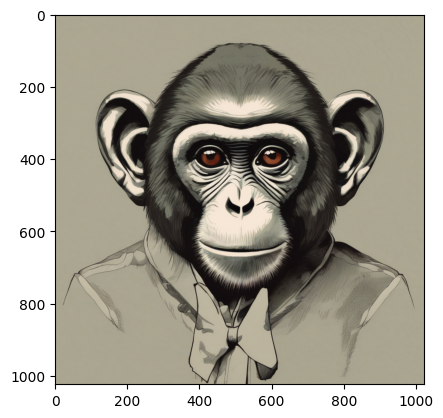

a purple crown and a blue bench 0.2869355082511902


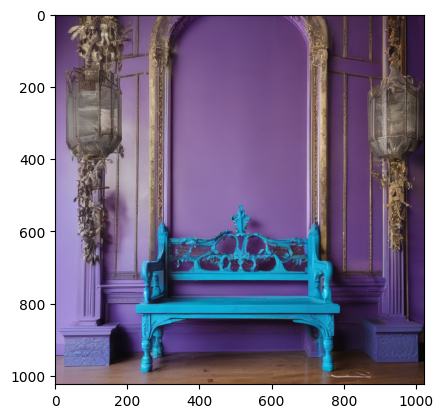

a white car and a black bowl 0.2811788320541382


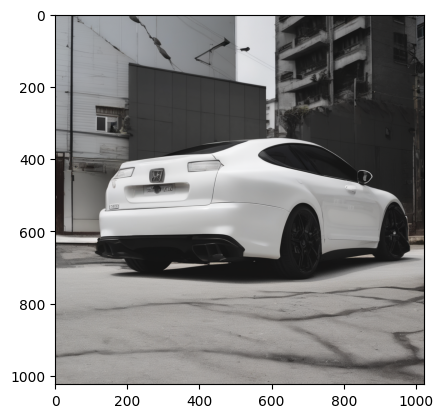

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

avg_clip_scores = dict()
for prompt in raw_metrics.keys():
    avg_clip_scores[prompt] = np.mean(raw_metrics[prompt]["full_text"])
# sort the prompts by the avg_clip_scores
sorted_prompts = sorted(avg_clip_scores, key=lambda x: avg_clip_scores[x], reverse=True)
for prompt in sorted_prompts[-10:]:
    print(prompt, avg_clip_scores[prompt])
    # show the corresponding image
    plt.clf()
    plt.close("all")
    _, ax = plt.subplots(1, 1)
    files = glob.glob(target_folder+f"_filtered/{prompt}/*.png")
    ax.imshow(Image.open(files[0]))
    plt.show()

a purple crown and a blue bench


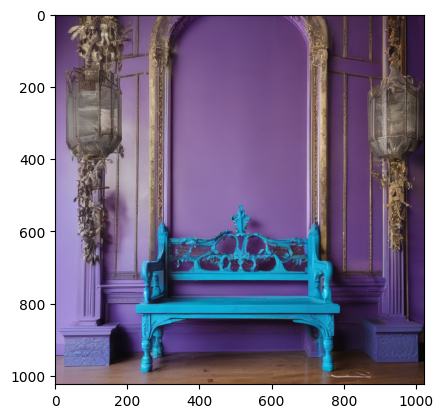

0.2869355082511902


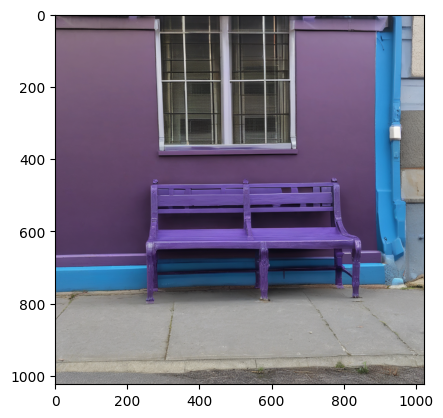

ValueError: '1.png' is not in list

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
# show images
for prompt in ["a purple crown and a blue bench"]:
    print(prompt)
    for idx, i in enumerate(range(5)):
        plt.imshow(Image.open(f"./outputs/standard_sd_xl_lift/{prompt}/{i}.png"))
        plt.show()
        # print the score
        idx = raw_metrics[prompt]['image_names'].index(f"{i}.png")
        print(raw_metrics[prompt]["full_text"][idx])


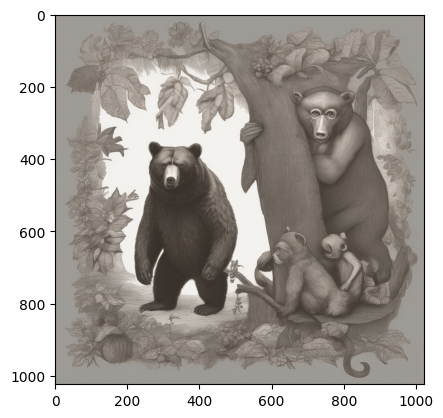

In [16]:
files = glob.glob(f"./outputs/standard_sd_xl_lift_filtered/{prompt}/*.png")
plt.imshow(Image.open(files[0]))
plt.show()
